In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage import util


In [2]:
def model(rd_a, rd_b, k_a, k_b, lap_a, lap_b, diff_a, diff_b, dt, inf_a, inf_b, sup_a, sup_b, wrap):

    if wrap:
        ndimage.convolve(rd_a, k_a, output=lap_a, mode='wrap')
        ndimage.convolve(rd_b, k_b, output=lap_b, mode='wrap')
    else:
        ndimage.convolve(rd_a, k_a, output=lap_a, mode='reflect')
        ndimage.convolve(rd_b, k_b, output=lap_b, mode='reflect')

    na = rd_a + (16 - rd_a * rd_b + diff_a * lap_a) * dt
    nb = rd_b + (rd_a * rd_b - rd_b - 12 + diff_b * lap_b) * dt

    global a, b
    np.clip(na, inf_a, sup_a, out=a)
    np.clip(nb, inf_b, sup_b, out=b)


In [3]:
from matplotlib.colors import Normalize


def getArtist(A, B):
  fig, ax = plt.subplots(1, 2)

  ax[0].set_title("Reagent A")
  ax[1].set_title("Reagent B")

  global imA, imB
  imA = ax[0].imshow(A, animated=True, cmap='inferno', interpolation='bicubic')
  imB = ax[1].imshow(B, animated=True, cmap='inferno', interpolation='bicubic')

  ax[0].axis('off')
  ax[1].axis('off')

  return fig


def updateAnimationEuler(f_id, it, A, B, ka, kb, da, db, la, lb, dt):
  global imA, imB

  for _ in range(it):
    #   (rd_a, rd_b, k_a, k_b, lap_a, lap_b, diff_a, diff_b, dt, inf_a, inf_b, sup_a, sup_b, wrap):
    model(A, B, ka, kb, la, lb, da, db, dt, inf_a=0,
          inf_b=0, sup_a=1000, sup_b=1000, wrap=True)

  global a, b
  imA.set_array(a)
  imB.set_array(b)

  # renormalize the colors
  imA.set_norm(Normalize(vmin=np.amin(A), vmax=np.amax(a)))
  imB.set_norm(Normalize(vmin=np.amin(B), vmax=np.amax(b)))

  return imA, imB


In [4]:
# kernels  0   1   2   3   4   5   6    7    8    9   10   11
# degrees  0  15  30  45  60  75  90  105  120  135  150  165

# Anisotropic kernels
kernels = (
    np.array([[0.135, 0.249, 0.135], [
             0.539, -2.116, 0.539], [0.135, 0.249, 0.135]]),
    np.array([[0.091, 0.263, 0.198], [
             0.512, -2.128, 0.512], [0.198, 0.263, 0.091]]),
    np.array([[0.069, 0.302, 0.262], [
             0.445, -2.157, 0.445], [0.262, 0.302, 0.069]]),
    np.array([[0.062, 0.367, 0.291], [
             0.367, -2.173, 0.367], [0.291, 0.367, 0.062]]),
    np.array([[0.069, 0.445, 0.262], [
             0.302, -2.157, 0.302], [0.262, 0.445, 0.069]]),
    np.array([[0.091, 0.512, 0.198], [
             0.263, -2.128, 0.263], [0.198, 0.512, 0.091]]),
    np.array([[0.135, 0.539, 0.135], [
             0.249, -2.116, 0.249], [0.135, 0.539, 0.135]]),
    np.array([[0.198, 0.512, 0.091], [
             0.263, -2.128, 0.263], [0.091, 0.512, 0.198]]),
    np.array([[0.262, 0.445, 0.069], [
             0.302, -2.157, 0.302], [0.069, 0.445, 0.262]]),
    np.array([[0.291, 0.367, 0.062], [
             0.367, -2.173, 0.367], [0.062, 0.367, 0.291]]),
    np.array([[0.262, 0.302, 0.069], [
             0.445, -2.157, 0.445], [0.069, 0.302, 0.262]]),
    np.array([[0.198, 0.263, 0.091], [0.512, -2.128, 0.512], [0.091, 0.263, 0.198]]))

# Isotropic kernel
iso = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]]) / 6


In [5]:
from matplotlib.animation import FuncAnimation


def rdAni(ratio, scale, shape=150, seed=1, stop=10000, ini_a=4, ini_b=4, delta_t=0.001, kernel_a = iso, time=3, fps=24):
  np.random.seed(seed)

  ka = kernel_a
  kb = iso

  da = ratio * scale
  db = scale

  shape = (shape, shape)
  dt = delta_t

  global a, b
  a = np.full(shape, ini_a, dtype=float)
  b = np.full(shape, ini_b, dtype=float) + np.random.rand(shape[0], shape[1])

  fig = getArtist(a, b)

  la = np.empty_like(a)
  lb = np.empty_like(b)

  it = time * fps
  args = (it, a, b, ka, kb, da, db, la, lb, dt)

  ani = FuncAnimation(fig,
                      updateAnimationEuler,
                      fargs=args,
                      interval=10,
                      frames=int(stop / it),
                      blit=True,
                      repeat=True,
                      )

  ani.save(f'gifs/r{ratio}s{scale}.gif', fps=fps, savefig_kwargs=dict(facecolor='#EAEAF2'))


MovieWriter ffmpeg unavailable; using Pillow instead.


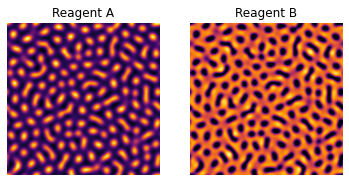

In [24]:
rdAni(7, 3)


MovieWriter ffmpeg unavailable; using Pillow instead.


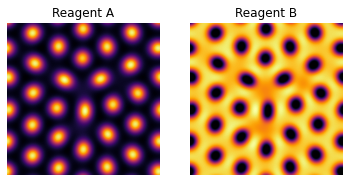

In [32]:
4.1, 18.1,  49, 25000

rdAni(4.1, 18.1, stop=25000, delta_t=0.0049)


MovieWriter ffmpeg unavailable; using Pillow instead.


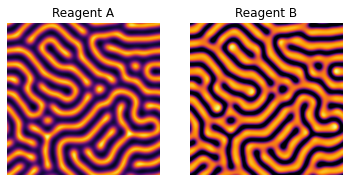

In [25]:
rdAni(10.3, 4.1, stop=30000, delta_t=0.005)


MovieWriter ffmpeg unavailable; using Pillow instead.


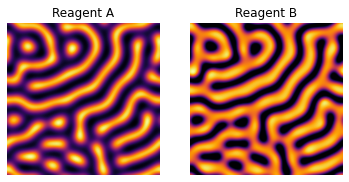

In [28]:
rdAni(10.3, 8.8, stop=35000, delta_t=0.001)


MovieWriter ffmpeg unavailable; using Pillow instead.


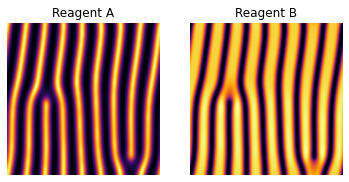

In [7]:
rdAni(6, 8, stop=20000, delta_t=0.0075, kernel_a=kernels[0])
